In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from mtcnn import MTCNN
import tensorflow as tf
import torch
from torchvision import transforms

In [2]:
tf.keras.utils.disable_interactive_logging()

In [3]:
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = 'cuda' if use_cuda else 'cpu'

True


In [4]:
current_device = torch.cuda.current_device()
device_name = torch.cuda.get_device_name(current_device)
device_property = torch.cuda.get_device_properties(current_device)
print(f'Device Name {device_name}')
print(f'Device Properties: {device_property}')

Device Name NVIDIA GeForce GTX 1650
Device Properties: _CudaDeviceProperties(name='NVIDIA GeForce GTX 1650', major=7, minor=5, total_memory=4095MB, multi_processor_count=14)


# Configurations

In [5]:
class EmotionLabel:
    labels = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']
    
    @staticmethod
    def get_label(index):
        return EmotionLabel.labels[index]
    
    @staticmethod
    def get_index(label):
        return EmotionLabel.labels.index(label)

In [6]:
USE_ENET2 = False
NUM_EMOTIONS = 7
assert len(EmotionLabel.labels) == NUM_EMOTIONS

In [7]:
IMG_SIZE = 224
MODEL_PATH = '../../models/raf/efficientnet_b0_robust_softmax.pt'

In [8]:
test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]
)
model = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
model = model.to(device)
model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=

# Demo

In [9]:
face_detector = MTCNN()

## Test on Image

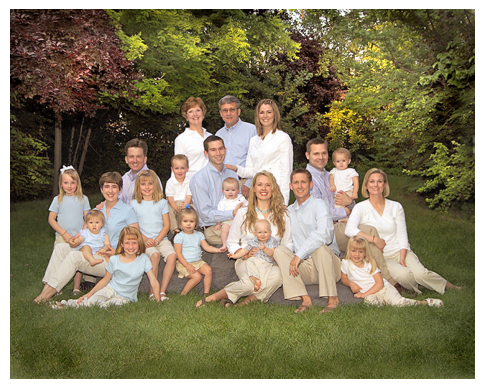

In [10]:
file_path = './test_media/imgs/big-family-2.png'
img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)

In [11]:
detected_faces = face_detector.detect_faces(img)
num_detected_faces = len(detected_faces)
print(f"Number of detected faces: {num_detected_faces}")
if num_detected_faces:
    print(f"Example: {detected_faces[0]}")

Number of detected faces: 20
Example: {'box': [482, 218, 27, 35], 'confidence': 0.999984860420227, 'keypoints': {'left_eye': (492, 233), 'right_eye': (505, 232), 'nose': (501, 240), 'mouth_left': (492, 245), 'mouth_right': (505, 244)}}


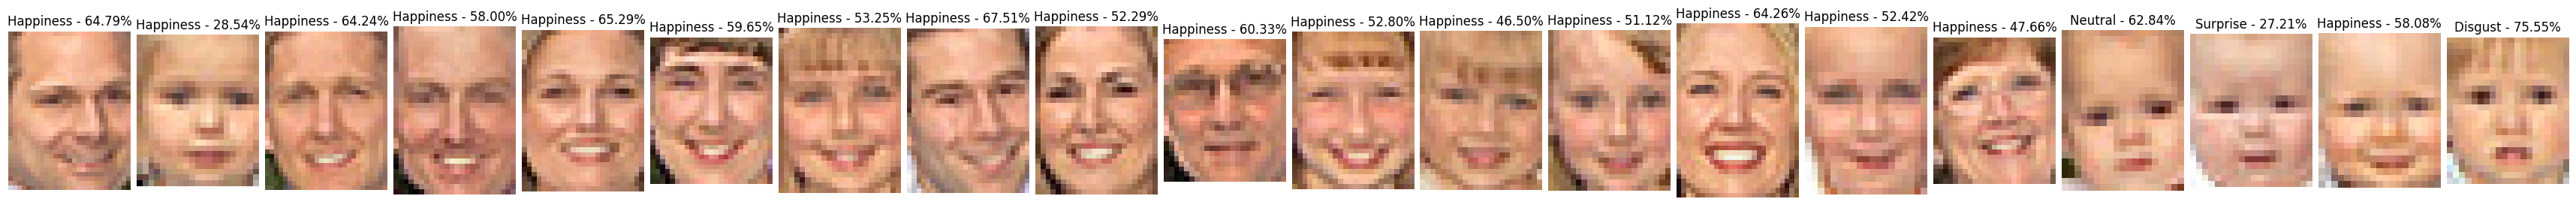

In [12]:
plt.figure(figsize=(num_detected_faces * 2.2, 10))

if num_detected_faces:
    for i, face in enumerate(detected_faces):
        box = face['box']
        x, y, w, h = box[0:4]
        cropped_face = img[y:y+h, x:x+w, :]

        # Predict emotion
        img_tensor = test_transforms(Image.fromarray(cropped_face))
        img_tensor.unsqueeze_(0)
        scores = model(img_tensor.to(device))
        scores = scores[0].data.cpu().numpy()

        # Create a subplot for each face
        plt.subplot(1, len(detected_faces), i+1)
        plt.imshow(cropped_face)
        plt.axis('off')

        # Annotate emotion label
        emotion = EmotionLabel.get_label(np.argmax(scores))
        prob = np.max(scores)
        plt.title(f"{emotion} - {prob * 100.0:.2f}%")

    plt.subplots_adjust(wspace=0.05)
    plt.show()
else:
    print("No faces detected!")

## Test on Video

In [13]:
# Process every frame of the video, write all the annotated frames to the output video 'output1.mp4'

file_path = './test_media/vids/pedestrian.mp4'

cap = cv2.VideoCapture(file_path)

# Get the dimensions of the frame
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
out = cv2.VideoWriter('./output/output1.mp4', fourcc, 20.0, (frame_width, frame_height))

# Create a list to store output images
output_images = []

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        # Detect faces
        detected_faces = face_detector.detect_faces(frame)

        for face in detected_faces:
            box = face['box']
            x, y, w, h = box[0:4]
            cropped_face = frame[y:y+h, x:x+w, :]

            # Predict emotion
            img_tensor = test_transforms(Image.fromarray(cropped_face))
            img_tensor.unsqueeze_(0)
            scores = model(img_tensor.to(device))
            scores = scores[0].data.cpu().numpy()

            # Draw rectangle around the face
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

            # Annotate emotion label
            emotion = EmotionLabel.get_label(np.argmax(scores))
            cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

        # Write the frame into the file 'output.mp4'
        out.write(frame)

        # Save the frame to the list of output images
        output_images.append(frame)

        # Quit if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Release everything when done
cap.release()
out.release()
cv2.destroyAllWindows()

In [14]:
print(f"Number of processed frames: {len(output_images)}")

Number of processed frames: 105


In [15]:
# With frame skipping (frame_skip=5), only include annotated frames

frame_skip = 5
frame_count = 0

file_path = './test_media/vids/pedestrian.mp4'
cap = cv2.VideoCapture(file_path)

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('./output/output2.mp4', fourcc, 20.0, (frame_width, frame_height))

output_images = []

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        frame_count += 1
        if frame_count % frame_skip == 0:
            detected_faces = face_detector.detect_faces(frame)
            for face in detected_faces:
                box = face['box']
                x, y, w, h = box[0:4]
                cropped_face = frame[y:y+h, x:x+w, :]
                
                img_tensor = test_transforms(Image.fromarray(cropped_face))
                img_tensor.unsqueeze_(0)
                scores = model(img_tensor.to(device))
                scores = scores[0].data.cpu().numpy()
                
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                
                emotion = EmotionLabel.get_label(np.argmax(scores))
                cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)
            out.write(frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

print(f"Frame rate: {cap.get(cv2.CAP_PROP_FPS)}")

cap.release()
out.release()
cv2.destroyAllWindows()

Frame rate: 25.0


In [16]:
# frame skipping (frame_skip = 5), include both annotated frames and original frames

frame_skip = 5
frame_count = 0

file_path = './test_media/vids/pedestrian.mp4'
cap = cv2.VideoCapture(file_path)

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('./output/output3.mp4', fourcc, 20.0, (frame_width, frame_height))

output_images = []

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        frame_count += 1
        if frame_count % frame_skip == 0:
            detected_faces = face_detector.detect_faces(frame)
            for face in detected_faces:
                box = face['box']
                x, y, w, h = box[0:4]
                cropped_face = frame[y:y+h, x:x+w, :]
                
                img_tensor = test_transforms(Image.fromarray(cropped_face))
                img_tensor.unsqueeze_(0)
                scores = model(img_tensor.to(device))
                scores = scores[0].data.cpu().numpy()
                
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                
                emotion = EmotionLabel.get_label(np.argmax(scores))
                cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)
                
        out.write(frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

print(f"Frame rate: {cap.get(cv2.CAP_PROP_FPS)}")

cap.release()
out.release()
cv2.destroyAllWindows()

Frame rate: 25.0
